In [27]:
# Data analysis
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import scipy as scipy


#PyTorch
import torch

# Custom modules 
from Modules.LinearModels.CVLinearModels import PairwiseMetrics
from Modules.FingerPrints.ParsingFunctions import get_sub_dict
from Modules.FingerPrints.GeneratingFunctions import FirstDegreeFP
from Modules.FingerPrints.KernelFP import KernelFPGenerator
from Modules.NeuralNetworks.MRLoss.RankNETMR import DataloaderRankNet
from Modules.NeuralNetworks.MRLoss.CVNNMR import NestedCV,RankNETCV,ILD_cv
from Modules.HelperFunctions import *
# CONSTANTS
from pathlib import Path
import csv
# Get the directory of the current file
current_dir = Path().cwd()
METABOBASE_PATH = current_dir.parent / "data" / "IDB.csv"
ARTICLES_PATH = current_dir.parent / "data"  / "ILD.csv"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


# Data

In [28]:
FPGen = KernelFPGenerator(generating_function=FirstDegreeFP,parsing_function=get_sub_dict)

## IMB

In [29]:
mb_data = pd.read_csv(METABOBASE_PATH)
dois_mb = mb_data['DOI'].to_numpy()
X_mb = np.stack(mb_data['SMILES'].apply(FPGen.generate))
y_mb = mb_data['RT'].to_numpy()
f_mb = mb_data['Formula'].to_numpy()

In [30]:
X_mb_tensor = torch.tensor(X_mb,dtype=torch.float32,device=DEVICE)
y_mb_tensor = torch.tensor(y_mb,dtype=torch.float32,device=DEVICE)

## ILD

In [31]:
a_data = pd.read_csv(ARTICLES_PATH)

X_a = np.stack(a_data['SMILES'].apply(FPGen.generate).to_numpy())
f_a = a_data['FORMULA'].to_numpy()
RTs_a = a_data['RT'].to_numpy()
dois_a = a_data['DOI'].to_numpy()
y_a = a_data['RT'].to_numpy()

In [32]:
X_a_tensor = torch.tensor(X_a,dtype=torch.float32,device=DEVICE)
y_a_tensor = torch.tensor(y_a,dtype=torch.float32,device=DEVICE)

## Stratification

In [33]:
def get_retention_time_class(retention_time, retention_times=y_mb, num_classes=3):
  """
  Determines the retention time class for a given retention time.

  Args:
    retention_time: The retention time of the compound.
    retention_times: A list or array of all retention times in the dataset.
    num_classes: The desired number of retention time classes.

  Returns:
    The retention time class (an integer between 0 and num_classes-1).
  """

  # Calculate class boundaries
  min_rt = np.min(retention_times)
  max_rt = np.max(retention_times)
  class_boundaries = np.linspace(min_rt, max_rt+0.001, num_classes+1)

  # Determine the class index
  class_index = np.digitize(retention_time, class_boundaries) - 1
  return class_index


classes = list(map(get_retention_time_class,y_mb))

# RankNET MRLoss

## Nested CV

In [ ]:
param_values = {
    "hidden_dim": [32,64],
    "n_hidden": [2,4],
    "num_epochs": [5,10],
    "weight_decay": [0.01,0.0001,0],
    "batch_size": [512]
} 
RD_acc_idb = RelDiffErrorAccumulator()
hyperparameters_grid = create_hp_grid(param_values)
RankNET_nested = np.array(NestedCV(X_mb_tensor,y_mb_tensor,classes,f_mb,hyperparameters_grid,RankNETCV,n_itter_inner=10,n_itter_out=10,accumulator=RD_acc_idb))
save_dir = current_dir.parent / "output" / 'IDB_results_p1' / 'NNMR.csv'
np.savetxt(save_dir,RankNET_nested)

In [ ]:
def write_accumulator_to_csv(accumulator, output_path):
    """
    Writes the contents of a RelDiffErrorAccumulator instance to a CSV file.

    Parameters:
    - accumulator: an instance of RelDiffErrorAccumulator
    - output_path: path to the output CSV file
    """
    with open(output_path, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['rel_diff', 'error', 'is_isomer'])  # header

        for rel_diff, error, is_isomer in zip(
            accumulator.rel_diffs,
            accumulator.errors,
            accumulator.isomeric_flags
        ):
            writer.writerow([rel_diff, int(error), int(is_isomer)])

write_accumulator_to_csv(RD_acc_idb,current_dir.parent/'output'/'Accumulators_IDB'/'NNMR.csv')

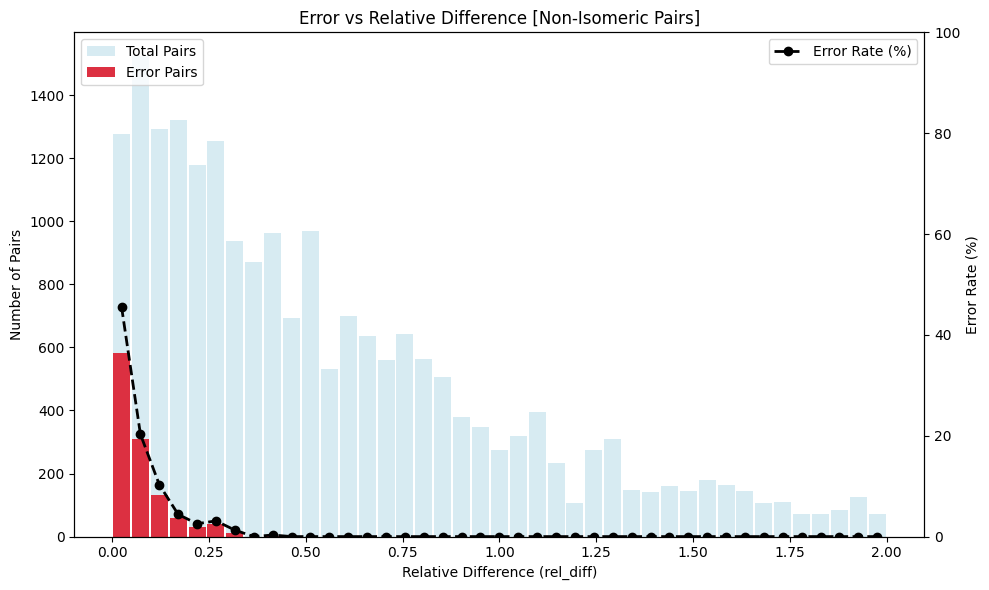

In [23]:
plot_rel_diff_error_distribution(RD_acc_idb,isomeric_only=False,bin_edges=np.linspace(0, 2.0, 42))

In [24]:
# Unweighted metrics (PER)
PER_test_mean, PER_test_std = np.mean(RankNET_nested[:, 0]), np.std(RankNET_nested[:, 0]) 
PER_mixed_mean, PER_mixed_std = np.mean(RankNET_nested[:, 1]), np.std(RankNET_nested[:, 1])

# Weighted metrics (iPER)
iPER_test_mean, iPER_test_ci = weighted_stats(RankNET_nested[:, 2], RankNET_nested[:, 4])
iPER_mixed_mean, iPER_mixed_ci = weighted_stats(RankNET_nested[:, 3], RankNET_nested[:, 5])

# Format for printing (in %)
results = {
    "PER (test)": format_result(PER_test_mean * 100, PER_test_std * 100),
    "PER (mixed)": format_result(PER_mixed_mean * 100, PER_mixed_std * 100),
    "iPER (test)": format_result(iPER_test_mean * 100, iPER_test_ci * 100),
    "iPER (mixed)": format_result(iPER_mixed_mean * 100, iPER_mixed_ci * 100)
}

# Print results
print("Evaluation Results (mean ± std):")
for name, value in results.items():
    print(f"{name:15s}: {value}")

Evaluation Results (mean ± std):
PER (test)     : 7.4 ± 4.4
PER (mixed)    : 6.0 ± 1.8
iPER (test)    : 18.0 ± 22.0
iPER (mixed)   : 12.7 ± 6.1


## Tuning HP on IDB

In [41]:
param_values = {
    "hidden_dim": [32,64],
    "n_hidden": [2,4],
    "num_epochs": [5,10],
    "weight_decay": [0.01,0.0001,0],
    "batch_size": [512]
} 

hyperparameters_grid = create_hp_grid(param_values)

In [42]:
RankNET_final = RankNETCV(X_mb_tensor,y_mb_tensor,classes,hyperparameters_grid,n_itter=10)

## Evaluating on ILD

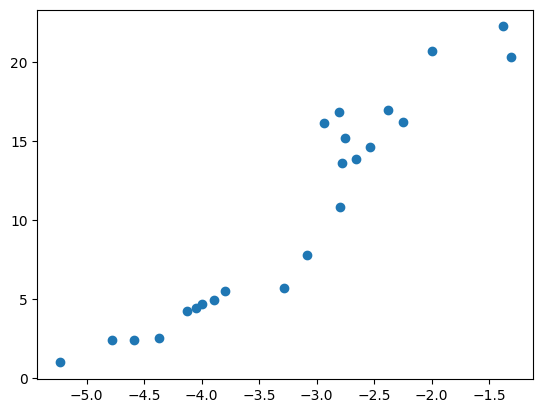

In [43]:
preds_articles = RankNET_final(X_a_tensor).cpu().detach().numpy().reshape(-1)
selected = dois_a == 'https://doi.org/10.1016/S0021-9673(01)95521-9'
plt.scatter(preds_articles[selected],y_a[selected])

In [44]:
PERs = []
n_pairs = []
iPERs = []
n_ipairs = []

n_samples = []
MAPE_reg = []
MedAPE_reg = []

MAPE_int = []
MedAPE_int = []

pairwise_rows = []
regression_rows = []

i = 0
s = list(set(dois_a))

for doi in s:
    selected = dois_a == doi
    num = sum(selected)
    # Compute stats for articles with 5 and more molecules, for more reliable performance estimation
    if num > 4:
        preds_sel = preds_articles[selected]
        y_sel = y_a[selected]
        f_sel = f_a[selected]

        RegMetrics = compute_safe_linear_regression_metrics(preds_sel, y_sel, n_splits=num)
        IntMetrics = compute_safe_interpolation_metrics(preds_sel, y_sel, n_splits=num)
        PMetrics = PairwiseMetrics(y_sel, preds_sel, np.array(range(num)), f_sel)

        # --- Regression/interpolation metrics ---
        n_samples.append(num)
        MAPE_reg.append(RegMetrics['MAPE'])
        MedAPE_reg.append(RegMetrics['MedAPE'])
        MAPE_int.append(IntMetrics['MAPE'])
        MedAPE_int.append(IntMetrics['MedAPE'])

        regression_rows.append({
            'DOI': doi,
            'n_samples': num,
            'MAPE_reg': RegMetrics['MAPE'],
            'MedAPE_reg': RegMetrics['MedAPE'],
            'MAPE_int': IntMetrics['MAPE'],
            'MedAPE_int': IntMetrics['MedAPE']
        })

        # --- Pairwise metrics ---
        per = PMetrics['PER_test']
        ni = PMetrics['ni_test']
        n_total_pairs = num * (num - 1) / 2

        PERs.append(per)
        n_pairs.append(n_total_pairs)

        row = {
            'DOI': doi,
            'n_pairs': n_total_pairs,
            'PER': per
        }

        if ni != 0:
            iPERs.append(PMetrics['iPER_test'])
            n_ipairs.append(ni)
            row['iPER'] = PMetrics['iPER_test']
            row['n_ipairs'] = ni
        else:
            row['iPER'] = ''
            row['n_ipairs'] = ''

        pairwise_rows.append(row)

# Convert to numpy arrays
PERs = np.array(PERs)
n_pairs = np.array(n_pairs)
iPERs = np.array(iPERs)
n_ipairs = np.array(n_ipairs)
MAPE_reg = np.array(MAPE_reg)
MedAPE_reg = np.array(MedAPE_reg)
MAPE_int = np.array(MAPE_int)
MedAPE_int = np.array(MedAPE_int)
n_samples = np.array(n_samples)

# Summary statistics
PER_str = format_result(*[x * 100 for x in weighted_stats(PERs, n_pairs)])
iPER_str = format_result(*[x * 100 for x in weighted_stats(iPERs, n_ipairs)])
MAPE_reg_str = format_result(*weighted_stats(MAPE_reg, n_samples))
MedAPE_reg_str = format_result(*weighted_stats(MedAPE_reg, n_samples))
MAPE_int_str = format_result(*weighted_stats(MAPE_int, n_samples))
MedAPE_int_str = format_result(*weighted_stats(MedAPE_int, n_samples))

results = {
    'PER': PER_str,
    'iPER': iPER_str,
    'MAPE_reg': MAPE_reg_str,
    'MedAPE_reg': MedAPE_reg_str,
    'MAPE_int': MAPE_int_str,
    'MedAPE_int': MedAPE_int_str
}

print("Evaluation Results:")
for name, value in results.items():
    print(f"{name:15s}: {value.split('±')[0]}%")

# --- Write to CSV files ---
with open(current_dir.parent / 'output' / 'ILD_results_p1' / 'NNMRPairM.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['DOI', 'n_pairs', 'PER', 'n_ipairs', 'iPER'])
    writer.writeheader()
    writer.writerows(pairwise_rows)

with open(current_dir.parent / 'output' / 'ILD_results_p1' / 'NNMRRegM.csv', 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['DOI', 'n_samples', 'MAPE_reg', 'MedAPE_reg', 'MAPE_int', 'MedAPE_int'])
    writer.writeheader()
    writer.writerows(regression_rows)


Evaluation Results:
PER            : 6.4 %
iPER           : 17.0 %
MAPE_reg       : 11.8 %
MedAPE_reg     : 10.2 %
MAPE_int       : 8.4 %
MedAPE_int     : 6.5 %


# Training on ILD

In [34]:
RD_acc = RelDiffErrorAccumulator()

In [35]:
param_values = {
    "hidden_dim": [32,64],
    "n_hidden": [2,4],
    "num_epochs": [5,10],
    "weight_decay": [0.01,0.0001,0],
    "batch_size": [512]
}
hyperparameters_grid = create_hp_grid(param_values)
train_loader = DataloaderRankNet(X_a_tensor,y_a_tensor,dois_a,batch_size=512)
ild_results,ild_reg_metrics,ild_int_metrics = ILD_cv(train_loader,X_mb_tensor,y_mb_tensor,classes,f_mb,hyperparameters_grid,n_itter=10,n_splits=5,accumulator=RD_acc)
ild_results,ild_reg_metrics,ild_int_metrics = np.array(ild_results),np.array(ild_reg_metrics), np.array(ild_int_metrics)
np.savetxt(current_dir.parent/'output'/'IDB_results_p2'/'NNMRR2.csv',ild_results)

In [36]:
def write_accumulator_to_csv(accumulator, output_path):
    """
    Writes the contents of a RelDiffErrorAccumulator instance to a CSV file.

    Parameters:
    - accumulator: an instance of RelDiffErrorAccumulator
    - output_path: path to the output CSV file
    """
    with open(output_path, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['rel_diff', 'error', 'is_isomer'])  # header

        for rel_diff, error, is_isomer in zip(
            accumulator.rel_diffs,
            accumulator.errors,
            accumulator.isomeric_flags
        ):
            writer.writerow([rel_diff, int(error), int(is_isomer)])

write_accumulator_to_csv(RD_acc,current_dir.parent/'output'/'Accumulators'/'NNMRR2.csv')

/Users/ivanrozanov/Desktop/FlavonoidsElutionOrder/Code/code/Modules/HelperFunctions.py:465: RuntimeWarning: invalid value encountered in divide
  error_rate = (error_counts / total_counts) * 100


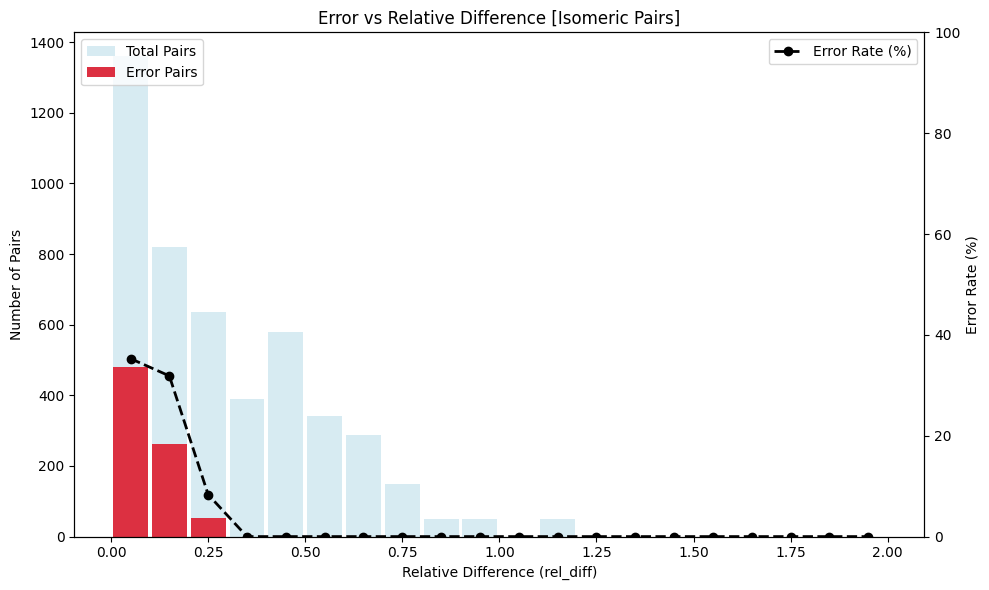

In [37]:
plot_rel_diff_error_distribution(RD_acc,isomeric_only=True,bin_edges=np.linspace(0, 2.0, 21))

In [38]:
# Unweighted metrics (PER)
PER_test_mean, PER_test_std = np.mean(ild_results[:, 0]), np.std(ild_results[:, 0])
PER_mixed_mean, PER_mixed_std = np.mean(ild_results[:, 1]), np.std(ild_results[:, 1])

# Weighted metrics (iPER)
iPER_test_mean, iPER_test_ci = weighted_stats(ild_results[:, 2], ild_results[:, 4])
iPER_mixed_mean, iPER_mixed_ci = weighted_stats(ild_results[:, 3], ild_results[:, 5])

# Format for printing (in %)
results = {
    "PER (test)": format_result(PER_test_mean * 100, PER_test_std * 100),
    "PER (mixed)": format_result(PER_mixed_mean * 100, PER_mixed_std * 100),
    "iPER (test)": format_result(iPER_test_mean * 100, iPER_test_ci * 100),
    "iPER (mixed)": format_result(iPER_mixed_mean * 100, iPER_mixed_ci * 100)
}

# Print results
print("Evaluation Results (mean ± std):")
for name, value in results.items():
    print(f"{name:15s}: {value}")

Evaluation Results (mean ± std):
PER (test)     : 10.11 ± 0.98
PER (mixed)    : 10.27 ± 0.2
iPER (test)    : 16.7 ± 4.7
iPER (mixed)   : 16.9 ± 3.4


In [39]:
# Unweighted metrics (PER)
MAPE, MAPE_std = np.mean(ild_reg_metrics[:, 0]), np.std(ild_reg_metrics[:, 0]) 
MedAPE, MedAPE_std = np.mean(ild_reg_metrics[:, 1]), np.std(ild_reg_metrics[:, 1])

# Format for printing (in %)
results = {
    "MAPE": format_result(MAPE, MAPE_std),
    "MedAPE": format_result(MedAPE, MedAPE_std),
}

# Print results
print("Evaluation Results (mean ± std):")
for name, value in results.items():
    print(f"{name:15s}: {value}")

Evaluation Results (mean ± std):
MAPE           : 9.53 ± 0.66
MedAPE         : 7.26 ± 0.88


In [40]:
# Unweighted metrics (PER)
MAPE, MAPE_std = np.mean(ild_int_metrics[:, 0]), np.std(ild_int_metrics[:, 0],ddof=1)
MedAPE, MedAPE_std = np.mean(ild_int_metrics[:, 1]), np.std(ild_int_metrics[:, 1],ddof=1)

# Format for printing (in %)
results = {
    "MAPE": format_result(MAPE, MAPE_std),
    "MedAPE": format_result(MedAPE, MedAPE_std),
}

# Print results
print("Evaluation Results (mean ± std):")
for name, value in results.items():
    print(f"{name:15s}: {value}")

Evaluation Results (mean ± std):
MAPE           : 10.0 ± 1.2
MedAPE         : 8.3 ± 1.3
